**Construção do modelo com Algoritmos de Machine Learning**

**Modelo 1: Regressão Logística**

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/dataset.zip -d /content/dataset


Archive:  /content/drive/MyDrive/dataset.zip
   creating: /content/dataset/processed_review_5.parquet/
  inflating: /content/dataset/__MACOSX/._processed_review_5.parquet  
  inflating: /content/dataset/processed_review_5.parquet/.part-00005-95f5e8b5-06bf-43b1-baf3-519fba0749d5-c000.snappy.parquet.crc  
  inflating: /content/dataset/__MACOSX/processed_review_5.parquet/._.part-00005-95f5e8b5-06bf-43b1-baf3-519fba0749d5-c000.snappy.parquet.crc  
  inflating: /content/dataset/processed_review_5.parquet/part-00004-95f5e8b5-06bf-43b1-baf3-519fba0749d5-c000.snappy.parquet  
  inflating: /content/dataset/__MACOSX/processed_review_5.parquet/._part-00004-95f5e8b5-06bf-43b1-baf3-519fba0749d5-c000.snappy.parquet  
  inflating: /content/dataset/processed_review_5.parquet/part-00003-95f5e8b5-06bf-43b1-baf3-519fba0749d5-c000.snappy.parquet  
  inflating: /content/dataset/__MACOSX/processed_review_5.parquet/._part-00003-95f5e8b5-06bf-43b1-baf3-519fba0749d5-c000.snappy.parquet  
  inflating: /content/

In [3]:
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz # Download Apache Sparks.
!tar xf spark-3.1.1-bin-hadoop3.2.tgz # Unzip the tgz file.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

# Initialize findspark
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [53.5 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [917 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,088 kB

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, length, dayofweek, when
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.ml.feature import Bucketizer
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, dayofweek, when, to_timestamp
from pyspark.ml.feature import Bucketizer, VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns


spark = SparkSession.builder \
    .appName("LogisticRegressionExample") \
    .getOrCreate()


df = spark.read.parquet("dataset/processed_review_1.parquet")

df = df.select('features', 'class')

df.printSchema()
df.show(5)

root
 |-- features: vector (nullable = true)
 |-- class: double (nullable = true)

+--------------------+-----+
|            features|class|
+--------------------+-----+
|(262144,[6346,223...|  0.0|
|(262144,[10049,99...|  0.0|
|(262144,[5537,259...|  0.0|
|(262144,[7625,853...|  0.0|
|(262144,[6949,302...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [7]:
class_distribution = df.groupBy("class").count().orderBy("class")
class_distribution.show()



train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

+-----+-----+
|class|count|
+-----+-----+
|  0.0|11774|
|  1.0|11620|
+-----+-----+



Training Logistic Regression...
Logistic Regression Test Accuracy = 0.74
Class 0.0:
  Precision = 0.74
  Recall = 0.75
  F1 Score = 0.74
Class 1.0:
  Precision = 0.74
  Recall = 0.72
  F1 Score = 0.73


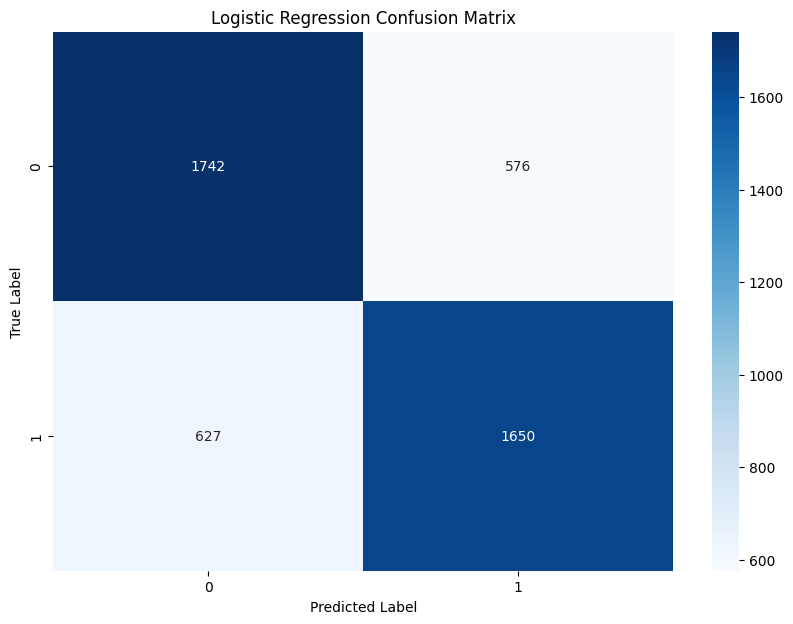

In [8]:
# Logistic Regression Model
model = LogisticRegression(labelCol="class")
model_name = "Logistic Regression"

print(f"Training {model_name}...")

# Pipeline construction
pipeline = Pipeline(stages=[model])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"{model_name} Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.show()

regression_evaluator = RegressionEvaluator(labelCol="class", predictionCol="prediction", metricName="rmse")
rmse = regression_evaluator.evaluate(predictions)
print(f"LR Test RMSE = {rmse}")

Training Decision Tree...
Decision Tree Test Accuracy = 0.67
Class 0.0:
  Precision = 0.63
  Recall = 0.85
  F1 Score = 0.73
Class 1.0:
  Precision = 0.77
  Recall = 0.49
  F1 Score = 0.60


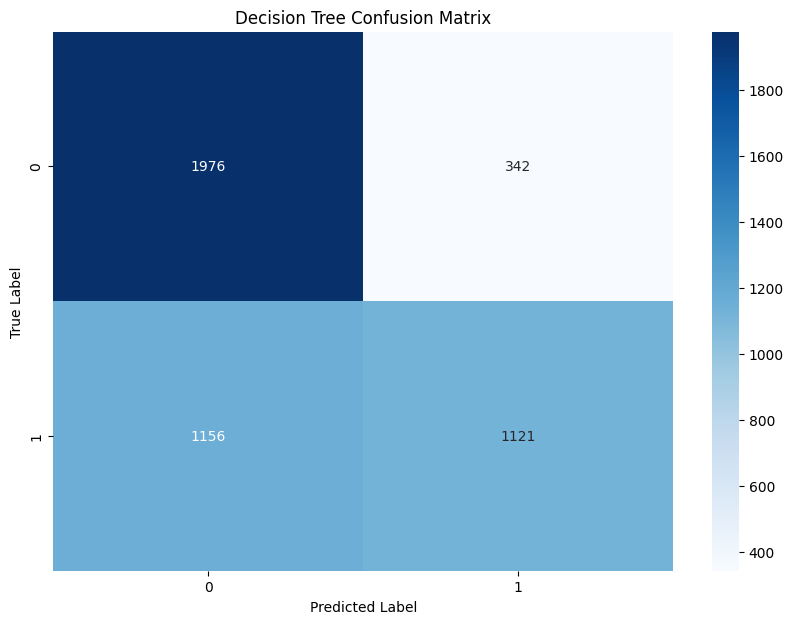

In [12]:
# Decision Tree Model
model = DecisionTreeClassifier(labelCol="class")
model_name = "Decision Tree"

print(f"Training {model_name}...")

# Pipeline construction
pipeline = Pipeline(stages=[model])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"{model_name} Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.show()

regression_evaluator = RegressionEvaluator(labelCol="class", predictionCol="prediction", metricName="rmse")
rmse = regression_evaluator.evaluate(predictions)
print(f"DT Test RMSE = {rmse}")

Training Random Forest...
Random Forest Test Accuracy = 0.61
Class 0.0:
  Precision = 0.63
  Recall = 0.56
  F1 Score = 0.59
Class 1.0:
  Precision = 0.60
  Recall = 0.67
  F1 Score = 0.63


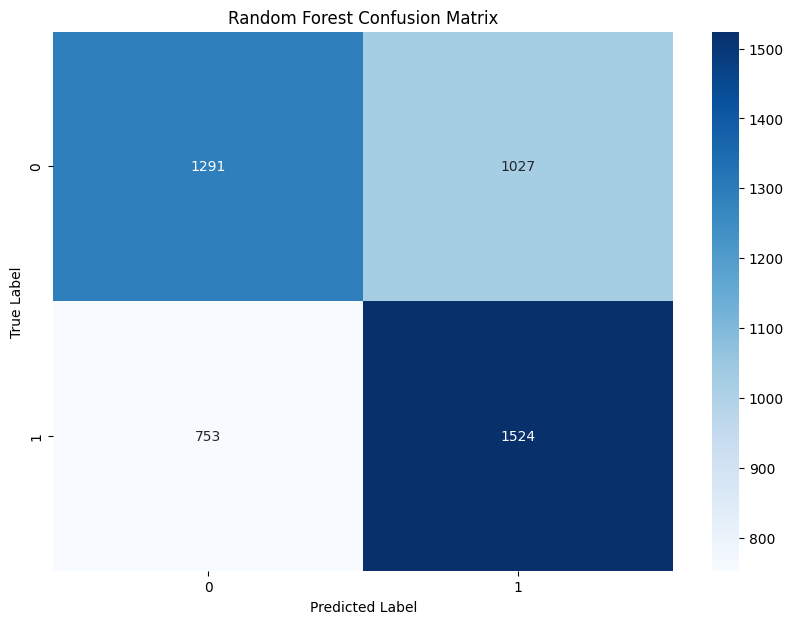

RF Test RMSE = 0.6223966455009172


In [13]:
# Random Forest Model
model = RandomForestClassifier(labelCol="class")
model_name = "Random Forest"

print(f"Training {model_name}...")

# Pipeline construction
pipeline = Pipeline(stages=[model])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"{model_name} Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.show()

regression_evaluator = RegressionEvaluator(labelCol="class", predictionCol="prediction", metricName="rmse")
rmse = regression_evaluator.evaluate(predictions)
print(f"RF Test RMSE = {rmse}")

Training Gradient-Boosted Trees...
Gradient-Boosted Trees Test Accuracy = 0.72
Class 0.0:
  Precision = 0.68
  Recall = 0.84
  F1 Score = 0.75
Class 1.0:
  Precision = 0.78
  Recall = 0.59
  F1 Score = 0.67


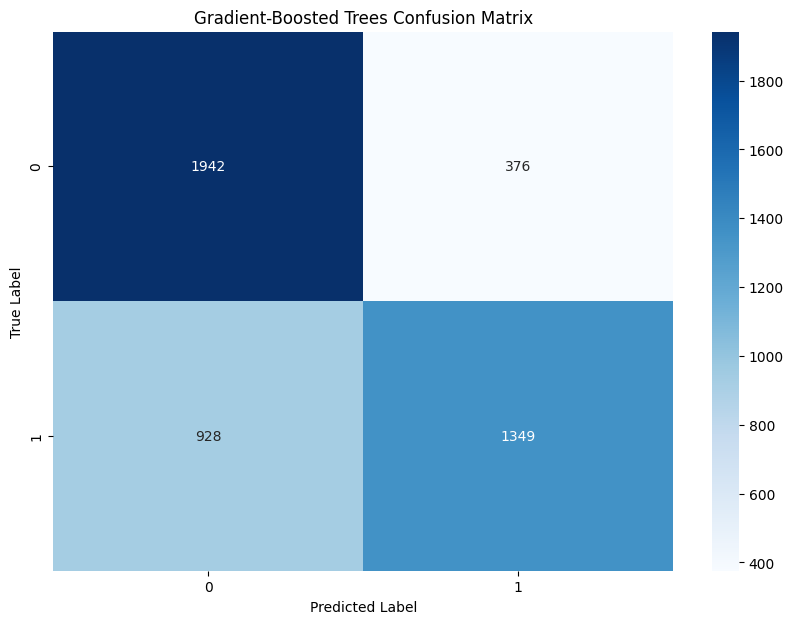

GT Test RMSE = 0.5327163642134167


In [15]:
# Gradient-Boosted Trees Model
model = GBTClassifier(labelCol="class")
model_name = "Gradient-Boosted Trees"

print(f"Training {model_name}...")

# Pipeline construction
pipeline = Pipeline(stages=[model])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"{model_name} Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.show()

regression_evaluator = RegressionEvaluator(labelCol="class", predictionCol="prediction", metricName="rmse")
rmse = regression_evaluator.evaluate(predictions)
print(f"GT Test RMSE = {rmse}")

Training SVM...
SVM Test Accuracy = 0.79
Class 0.0:
  Precision = 0.79
  Recall = 0.80
  F1 Score = 0.80
Class 1.0:
  Precision = 0.80
  Recall = 0.78
  F1 Score = 0.79


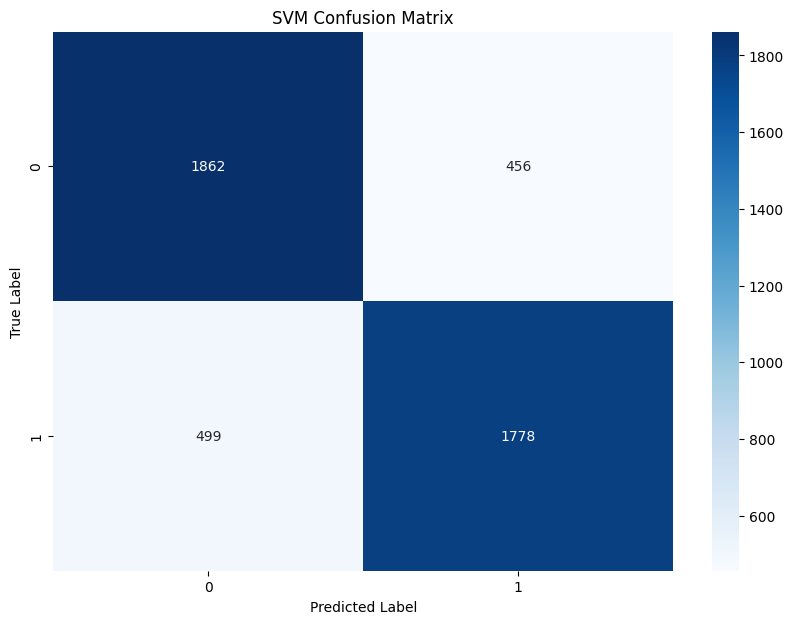

SVM Test RMSE = 0.45588880533432946


In [8]:
# SVM Model
model = LinearSVC(labelCol="class")
model_name = "SVM"

print(f"Training {model_name}...")

# Pipeline construction
pipeline = Pipeline(stages=[model])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"{model_name} Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.show()

regression_evaluator = RegressionEvaluator(labelCol="class", predictionCol="prediction", metricName="rmse")
rmse = regression_evaluator.evaluate(predictions)
print(f"SVM Test RMSE = {rmse}")

### NOTAS

• Por questões de produtividade, devem ser considerados dois conjuntos de dados aquando do desenvolvimento da solução. Assim, para além dos dados originais na sua integra, deve ser utilizado um conjunto de dados de menor dimensão (sub-conjunto dos anteriores), para o caso de tarefas intensivas e frequentes, inerentes ao próprio processo de desenvolvimento da solução.

• Cada notebook (ou módulo) deverá ser autónomo em termos de fontes de dados. Sugere se que estruturem o código por forma a ler e gravar os dados entre cada uma das etapas do projeto. Isto é particularmente importante para a parte da visualização: a geração
de um gráfico ou tabela não deverá implicar a realização da simulação/processamento no mesmo instante. Preferencialmente deverá importar os dados já processados a partir de ficheiros.

### Bibliografia

https://www.kaggle.com/datasets/naveedhn/amazon-product-review-spam-and-non-spam/data?select=Clothing_Shoes_and_Jewelry     https://ieeexplore.ieee.org/abstract/document/9027828

https://www.kaggle.com/code/abhilashsampath/amazon-review-spam-detection